# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели. 

**Цель:** В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для улучшения качества модели.

## Часть 1. EDA

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных. Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

## Часть 2. Preprocessing & Feature Engineering

Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.

Опробуйте различные техники:
- работа с категориальными переменными (можно начать с dummy)
- замена аномалий
- различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.)
- обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать

Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.

## Часть 3. Моделирование

1. Отложите 30% данных для тестирования
2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV
3. Измерьте качество каждой и визуализируйте важность признаков
3. Сделайте интересные выводы :)

В ноутбуке желательно видеть:
1) Понятное описание: какие техники и алгоритмы были опробованы - было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).
2) Наличие визуализаций (не обязательно строить много графиков - можно несколько репрезентативных)
3) Наличие хотя бы одной модификации данных, приводящей к улучшению результатов

## Критерии оценки
- EDA - 2 балла
- Базовая предобработка и построенные модели с оценкой качества - 4 балла
- Дополнительная генерация признаков и проверка качества моделей с ними - 4 балла

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics

%matplotlib inline

## Часть 1. EDA
### 1.1 Загрузка данных

Загружаем данные из датасета

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
data.shape

(48895, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### 1.2 Базовая предобработка переменных

Добавим в список на удаление переменные, которые интуитивно не влияют на результат: `id`, `name`, `host_id`, `host_name`, `last_review`.

In [5]:
TO_DROP = ['id', 'name', 'host_id', 'host_name', 'last_review']

In [6]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Получение базовых статистик датасета: средние, медиана, персентили

In [7]:
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Посмотрим есть ли незаполненные значения в данных.

In [8]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видно, из значимых столбцов незаполненные данные есть только в столбце `reviews_per_month` - количество отзывов в месяц. Давайте заменим нулями пустые значения.

In [9]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [10]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### 1.2 Визуализация данных

Сперва построим гистограммы и графики плотности распределения признаков.

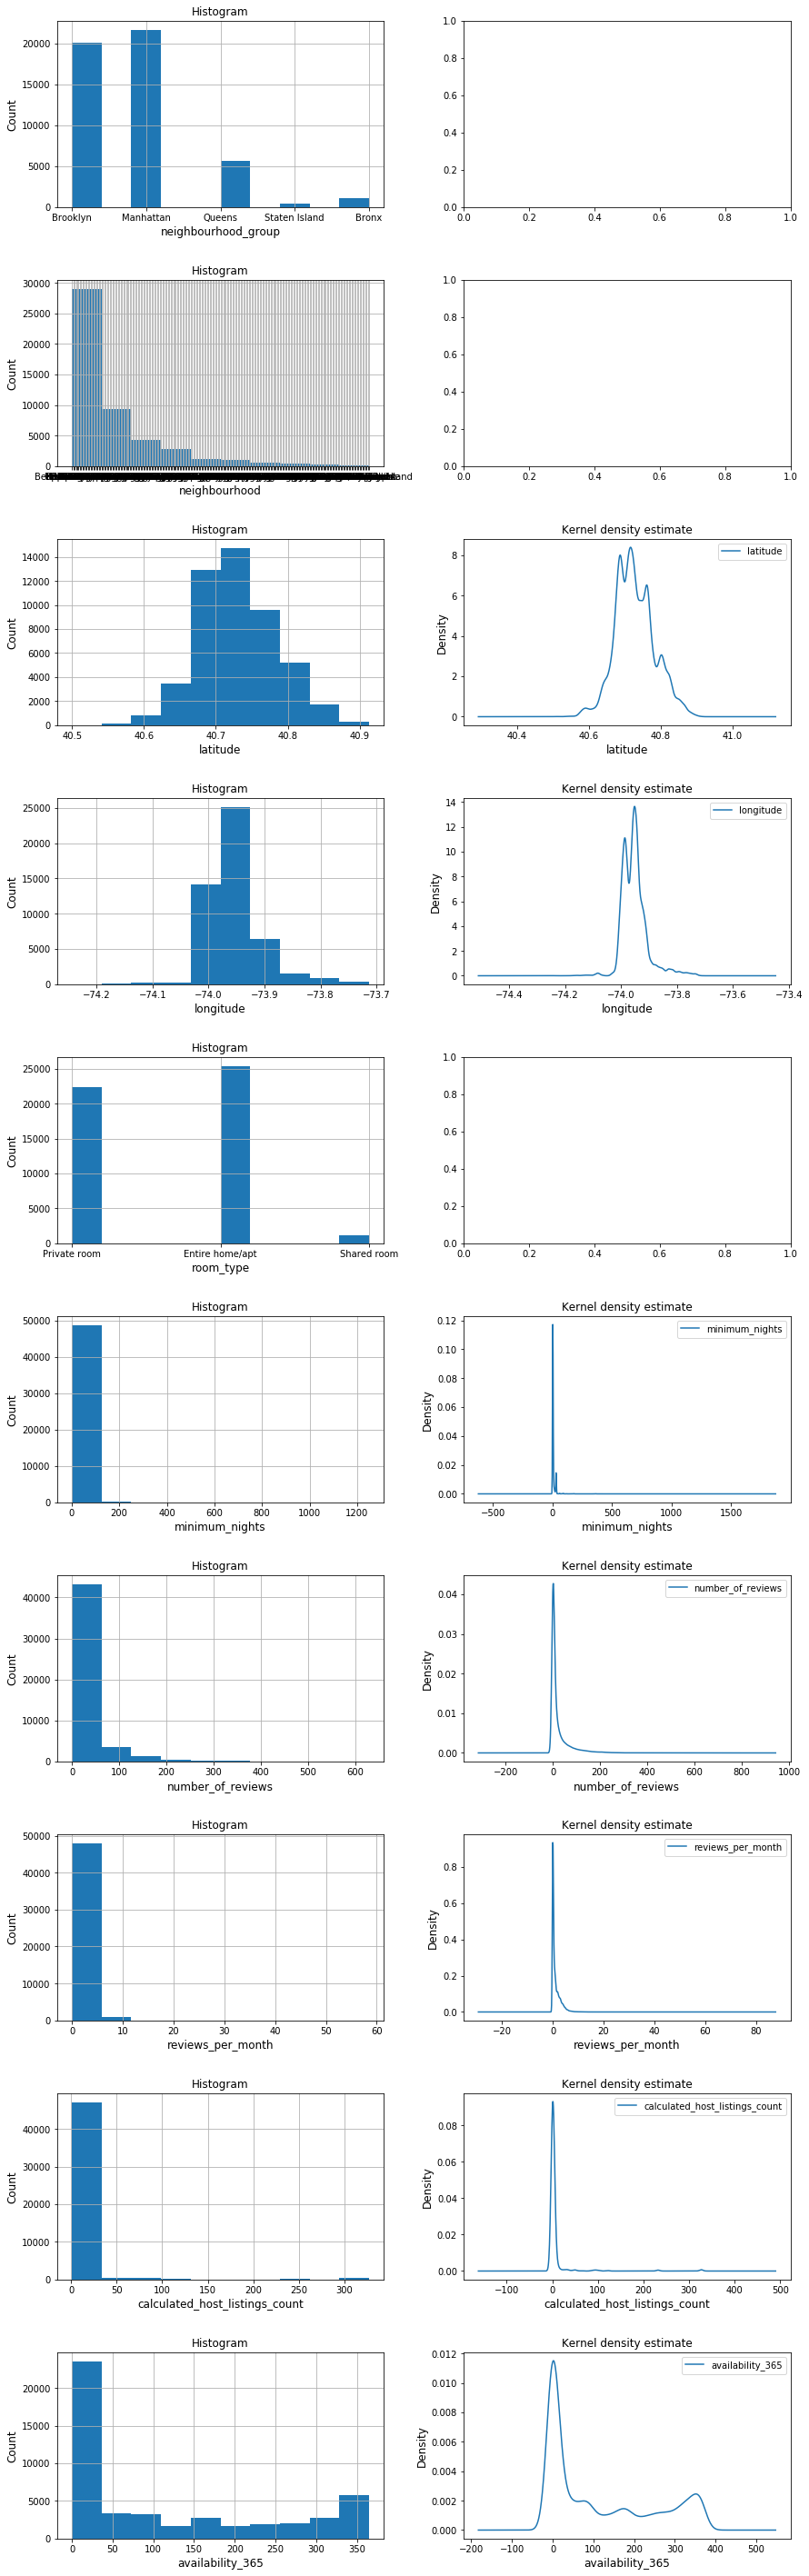

In [11]:
# Список колонок для построения графиков
columns = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
           'calculated_host_listings_count', 'availability_365']
categorical_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Создадим окружение для графиков, для каждой колонки два стобца
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(13,40))

for index, column in enumerate(columns):
    # В первом столбце отобразим гистограмму
    data[column].hist(ax=axs[index, 0])
    axs[index, 0].set_title('Histogram')
    axs[index, 0].set_xlabel(column, fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)

    if column in categorical_columns:
        continue
        
    # Во втором столбце отобразим график сглаженной плотности распределения на основе ядерной оценки
    data[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title('Kernel density estimate')
    axs[index, 1].set_xlabel(column, fontsize=12)
    axs[index, 1].set_ylabel('Density', fontsize=12)
    axs[index, 1].legend()

plt.tight_layout(pad=3.0)
plt.show()

### 1.3 Обработка категориальных переменных

Теперь обработаем категориальные переменные, переведем `neighbourhood_group` и `room_type` в переменные-индикаторы, а для переменной `neighbourhood` применим частотное кодирование.

#### Кодируем `neighbourhood_group`

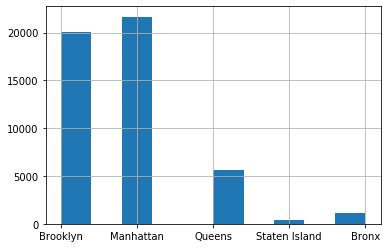

In [12]:
data['neighbourhood_group'].hist()
plt.show()

In [13]:
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [14]:
neighbourhood_group_encoded = pd.get_dummies(data['neighbourhood_group'], prefix='neighbourhood_group')
data = pd.concat([data, neighbourhood_group_encoded], axis=1)
TO_DROP.append('neighbourhood_group')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,9,2018-10-19,0.21,6,365,0,1,0,0,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,45,2019-05-21,0.38,2,355,0,0,1,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0,NaN,0.00,1,365,0,0,1,0,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,270,2019-07-05,4.64,1,194,0,1,0,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,9,2018-11-19,0.10,1,0,0,0,1,0,0


#### Кодируем `room_type`

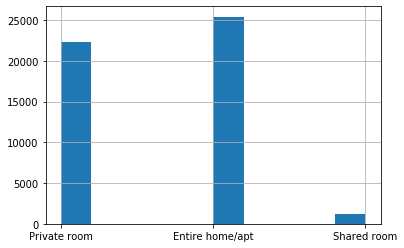

In [15]:
data['room_type'].hist()
plt.show()

In [16]:
data['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [17]:
room_type_encoded = pd.get_dummies(data['room_type'], prefix='room_type')
data = pd.concat([data, room_type_encoded], axis=1)
TO_DROP.append('room_type')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,6,365,0,1,0,0,0,0,1,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2,355,0,0,1,0,0,1,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,1,365,0,0,1,0,0,0,1,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,1,194,0,1,0,0,0,1,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,1,0,0,0,1,0,0,1,0,0


#### Кодируем `neighbourhood`

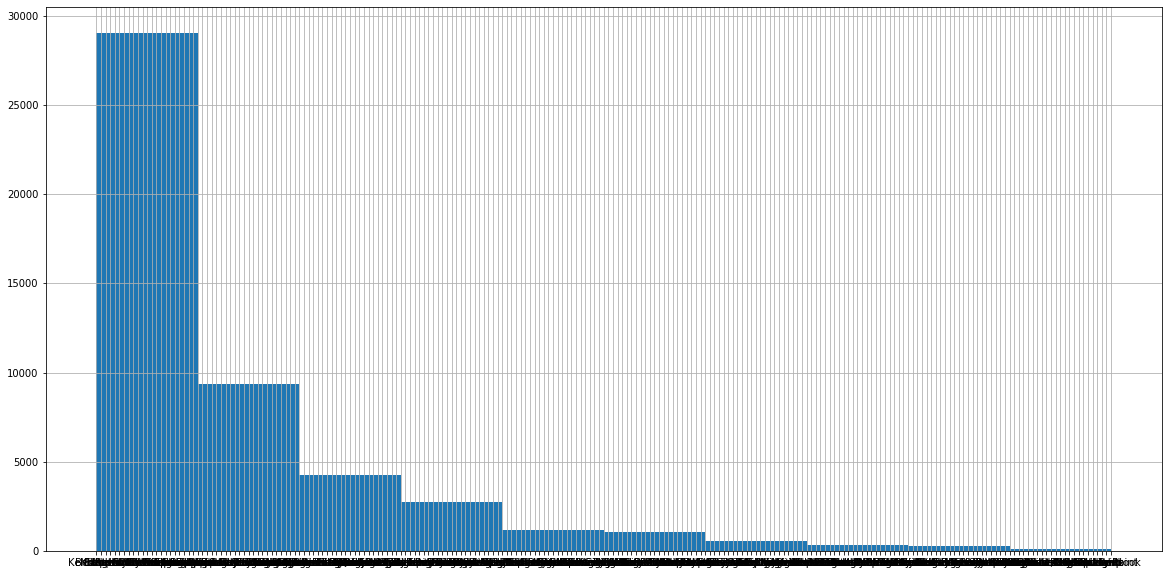

In [18]:
plt.figure(figsize=(20, 10))
data['neighbourhood'].hist()
plt.show()

In [19]:
data['neighbourhood'].value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Willowbrook              1
Rossville                1
New Dorp                 1
Fort Wadsworth           1
Richmondtown             1
Name: neighbourhood, Length: 221, dtype: int64

In [20]:
data['neighbourhood'].value_counts(normalize=True)

Williamsburg          0.080172
Bedford-Stuyvesant    0.075959
Harlem                0.054361
Bushwick              0.050414
Upper West Side       0.040311
                        ...   
Willowbrook           0.000020
Rossville             0.000020
New Dorp              0.000020
Fort Wadsworth        0.000020
Richmondtown          0.000020
Name: neighbourhood, Length: 221, dtype: float64

In [21]:
data['neighbourhood_encoded'] = data['neighbourhood'].map(data['neighbourhood'].value_counts(normalize=True))
TO_DROP.append('neighbourhood')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,365,0,1,0,0,0,0,1,0,0.003579
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,355,0,0,1,0,0,1,0,0,0.031598
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,365,0,0,1,0,0,0,1,0,0.054361
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,194,0,1,0,0,0,1,0,0,0.011699
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0,0,0,1,0,0,1,0,0,0.022845


### 1.4 Удаление ненужных колонок

In [22]:
data.drop(TO_DROP, axis=1, inplace=True)

In [23]:
data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,0.003579
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0,0.031598
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0,0.054361
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0,0.011699
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0,0.022845


### 1.3 Визуализация корреляции

Теперь построим тепловую карту для матрицы корреляций

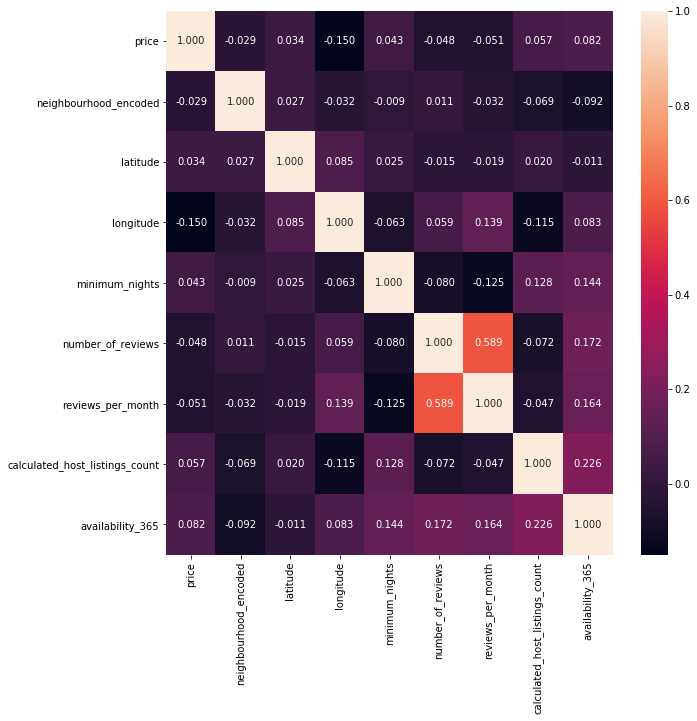

In [24]:
# Посчитаем матрицу корреляций для всех колонок
TO_CORR = ['price', 'neighbourhood_encoded', 'latitude', 'longitude', 'minimum_nights', 
           'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
corr = data[TO_CORR].corr()

# Отобразим ее на тепловой карте
plt.figure(figsize=(10,10));
sns.heatmap(corr, annot=True, fmt='.3f');

Как видно из графика корреляции, зависимыми друг от друга являются количество всех отзывов и количество отзывов в месяц. Построим графики парных корреляций, действительно ли между признаками наблюдается линейная зависимость.

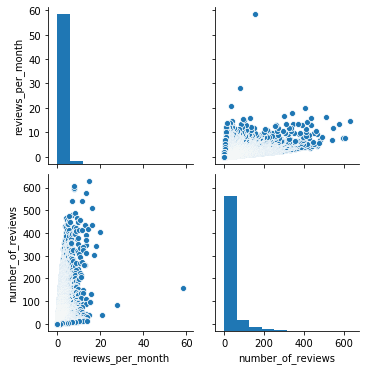

In [25]:
sns.pairplot(data[['reviews_per_month', 'number_of_reviews']], diag_kind="hist");

## Часть 2. Базовое моделирование

### 2.1 Подготовка данных

Сохраним в $X$ все колонки признаки, а в $y$ $-$ целевую переменную.

In [26]:
X = data.drop('price', axis=1)
y = data['price']

X.shape, y.shape

((48895, 16), (48895,))

Разобьем данные на тренировочный и тестовый наборы.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34226, 16), (14669, 16), (34226,), (14669,))

На данном этапе не будем проводить шкалирование, сделаем позже.

### 2.2 Построение моделей линейной регрессии

Создадим функцию, которая будет по заданному датасету и регрессору строить модель линейной регресиии, вычислять основные метрики качества и строить график важности признаков.

In [29]:
def init_metrics_table():
    metrics_table = pd.DataFrame({"error_type":["MAE", "RMSE", "R2"]})
    metrics_table.set_index("error_type")
    return metrics_table

In [30]:
def regression(X_train, X_test, y_train, y_test, regressor, regressor_name, metrics_table, plot_graphics):
    print('Регрессор:', regressor_name)
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    if (hasattr(regressor, 'alpha_')):
        print('Лучшее значение параметра регуляризации: {:.5f}'.format(regressor.alpha_))

    metrics_table[regressor_name] = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred)       
    ]

    if (plot_graphics):
        featureImportance = pd.DataFrame({"feature": X_train.columns[regressor.coef_!=0], 
                                          "importance": regressor.coef_[regressor.coef_!=0]})

        featureImportance.set_index('feature', inplace=True)
        featureImportance.sort_values(["importance"], ascending=False, inplace=True)

        featureImportance["importance"].plot(kind='bar', figsize=(10, 5));    
        plt.title("Feature Importance - " + regressor_name)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.show()

#### 3.2.1 Построение простой модели регрессии

Построим простую модель регрессии.

Регрессор: LinearRegression


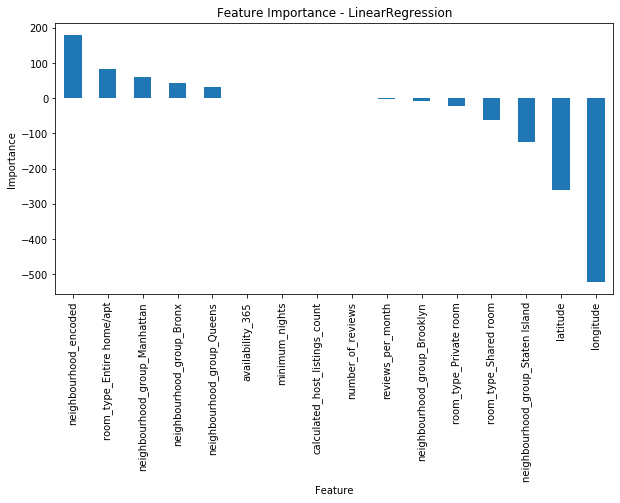

,error_type,LinearRegression
0,MAE,71.448396
1,RMSE,187.042839
2,R2,0.133762


In [31]:
metrics_table = init_metrics_table()

regression(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression', metrics_table, True)

metrics_table

#### 3.2.2 Построение модели регрессии RidgeCV

Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 0.10000


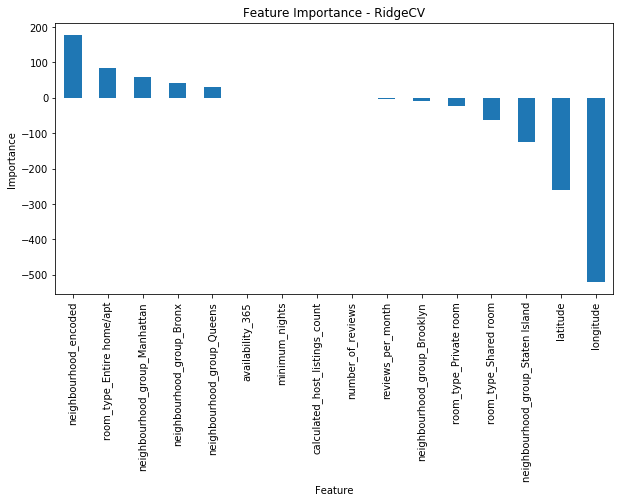

,error_type,LinearRegression,RidgeCV
0,MAE,71.448396,71.444968
1,RMSE,187.042839,187.042245
2,R2,0.133762,0.133767


In [32]:
regression(X_train, X_test, y_train, y_test, RidgeCV(cv=5), 'RidgeCV', metrics_table, True)

metrics_table

#### 3.2.3 Построение модели регрессии LassoCV

Регрессор: LassoCV
Лучшее значение параметра регуляризации: 2.61742


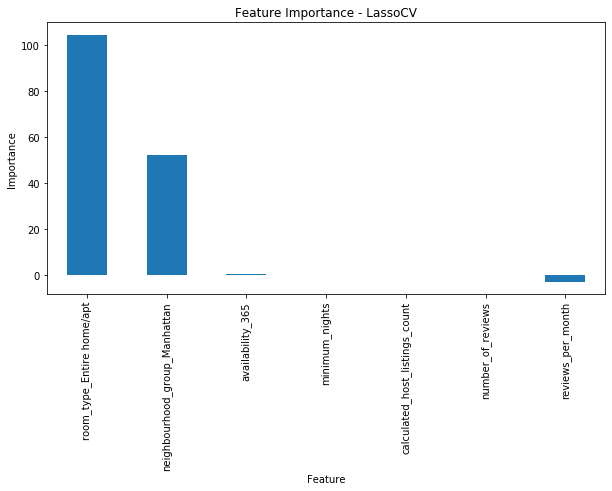

,error_type,LinearRegression,RidgeCV,LassoCV
0,MAE,71.448396,71.444968,71.421389
1,RMSE,187.042839,187.042245,188.070440
2,R2,0.133762,0.133767,0.124218


In [33]:
regression(X_train, X_test, y_train, y_test, LassoCV(), 'LassoCV', metrics_table, True)

metrics_table

#### 3.2.4 Построение модели регрессии ElasticNetCV

Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 5.23483


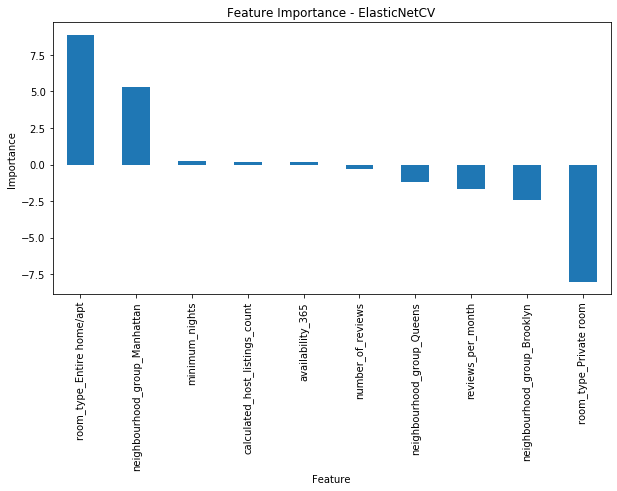

,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,71.448396,71.444968,71.421389,84.185747
1,RMSE,187.042839,187.042245,188.070440,196.556788
2,R2,0.133762,0.133767,0.124218,0.043398


In [34]:
regression(X_train, X_test, y_train, y_test, ElasticNetCV(cv=5), 'ElasticNetCV', metrics_table, True)

metrics_table

---

Теперь создадим функцию, которая будет вызывать все регрессоры и пересчитывать метрики

In [35]:
def all_regressions(X_train, X_test, y_train, y_test):
    metrics_table = init_metrics_table()
    
    regression(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression', metrics_table, False)
    regression(X_train, X_test, y_train, y_test, RidgeCV(cv=5), 'RidgeCV', metrics_table, False)
    regression(X_train, X_test, y_train, y_test, LassoCV(cv=5), 'LassoCV', metrics_table, False)
    regression(X_train, X_test, y_train, y_test, ElasticNetCV(cv=5), 'ElasticNetCV', metrics_table, False)
    
    return metrics_table

In [36]:
metrics_table = all_regressions(X_train, X_test, y_train, y_test)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 0.10000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 2.61742
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 5.23483


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,71.448396,71.444968,71.421389,84.185747
1,RMSE,187.042839,187.042245,188.070440,196.556788
2,R2,0.133762,0.133767,0.124218,0.043398


## Часть 3. Feature Engineering

In [37]:
def regressions_with_scaler(data, scaler, to_scale):
    X = data.drop('price', axis=1)
    y = data['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[to_scale] = scaler.fit_transform(X_train[to_scale])
    X_test_scaled[to_scale] = scaler.transform(X_test[to_scale])

    return all_regressions(X_train_scaled, X_test_scaled, y_train, y_test)

### Шкалирование данных

Сперва прошкалируем данные с помощью StandardScaler и посмотрим как поменяется результат.

In [38]:
TO_SCALE = ['neighbourhood_encoded', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365']   
    
metrics_table = regressions_with_scaler(data, StandardScaler(), TO_SCALE)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.03665
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.07331


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,71.448396,71.421794,71.400891,71.064859
1,RMSE,187.042839,187.041262,187.038519,187.399106
2,R2,0.133762,0.133777,0.133802,0.130459


Как можно заметить на шкалированных данных ошибка ElasticNetCV стал лучше работать. Теперь попробуем применить RobustScaler для шкалирования.

In [39]:
TO_SCALE = ['neighbourhood_encoded', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365']   

metrics_table = regressions_with_scaler(data, RobustScaler(), TO_SCALE)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.46412
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.92825


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,71.448396,71.419888,71.229220,73.826183
1,RMSE,187.042839,187.041125,187.177389,190.474986
2,R2,0.133762,0.133778,0.132515,0.101680


### Создание новых переменных

Попробуем добавить новую переменную, обозначающую, есть ли отзывы или нет.

In [40]:
data['number_of_reviews'].value_counts()

0      10052
1       5244
2       3465
3       2520
4       1994
       ...  
404        1
436        1
388        1
341        1
607        1
Name: number_of_reviews, Length: 394, dtype: int64

In [41]:
data_updated = data.copy()
data_updated['with_reviews'] = data_updated['number_of_reviews'] != 0

In [42]:
data_updated['with_reviews'].value_counts()

True     38843
False    10052
Name: with_reviews, dtype: int64

Построим модели регрессии с новой переменной и посмотрим на результат.

In [43]:
TO_SCALE = ['neighbourhood_encoded', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365']   

metrics_table = regressions_with_scaler(data_updated, StandardScaler(), TO_SCALE)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.03665
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.07331


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,71.598307,71.567637,71.543562,70.790440
1,RMSE,186.526631,186.523925,186.520750,186.847419
2,R2,0.138537,0.138562,0.138591,0.135571


Как можно заметить, результат поменялся не слишком сильно. Попробуем добавить другую переменную - расстояние от квартиры до центра Манхэттена. Сперва зададим функцию для подсчета расстояния между двумя точками.

In [44]:
def distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    delta_phi       = math.radians(lat2 - lat1)
    delta_lambda    = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(delta_lambda/2)**2
    
    R = 6372800
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

Теперь создадим новую переменную.

In [45]:
#data_updated = data.copy()

manhattan_coord = (40.758896, -73.985130)
data_updated['distance_to_manhattan'] = data_updated.apply(
    lambda x: distance(coord1 = manhattan_coord, coord2 = (x['latitude'], x['longitude'])), axis=1
)

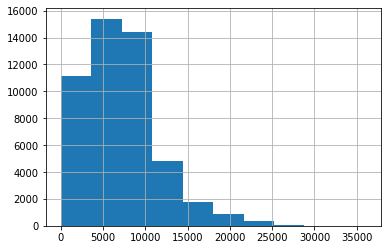

In [46]:
data_updated['distance_to_manhattan'].hist()

In [47]:
data_updated.drop(['latitude', 'longitude'], axis=1, inplace=True)
TO_SCALE = ['neighbourhood_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365', 'distance_to_manhattan']   

metrics_table = regressions_with_scaler(data_updated, StandardScaler(), TO_SCALE)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.09733
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.08426


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,71.103262,71.083976,70.955781,70.071335
1,RMSE,186.395806,186.393582,186.387624,186.531746
2,R2,0.139745,0.139765,0.139820,0.138489


Как видно, коэффициент $R^2$ немного вырос и снизились ошибки.

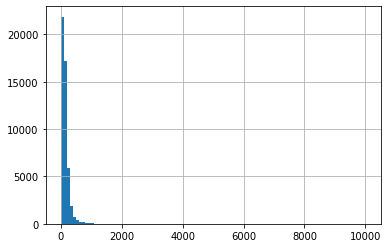

In [48]:
data['price'].hist(bins=100)

### Обработка выбросов

Теперь посмотрим, возможно можно улучшить модель путем обработки выбросов. Для определения выбросов будет использовать интерквартильное расстояние.

In [49]:
def outlier_detect_IQR(data, col, lower_border, upper_border):   
    tmp = pd.concat([data[col] > upper_border, data[col] < lower_border], axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1] / len(outlier_index))
    return outlier_index

In [50]:
data_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price                              48895 non-null  int64  
 1   minimum_nights                     48895 non-null  int64  
 2   number_of_reviews                  48895 non-null  int64  
 3   reviews_per_month                  48895 non-null  float64
 4   calculated_host_listings_count     48895 non-null  int64  
 5   availability_365                   48895 non-null  int64  
 6   neighbourhood_group_Bronx          48895 non-null  uint8  
 7   neighbourhood_group_Brooklyn       48895 non-null  uint8  
 8   neighbourhood_group_Manhattan      48895 non-null  uint8  
 9   neighbourhood_group_Queens         48895 non-null  uint8  
 10  neighbourhood_group_Staten Island  48895 non-null  uint8  
 11  room_type_Entire home/apt          48895 non-null  uin

---
#### minimum_nights

In [51]:
data['minimum_nights'].sort_values()

0           1
16078       1
16090       1
16096       1
16099       1
         ... 
13404     999
26341     999
38664     999
2854     1000
5767     1250
Name: minimum_nights, Length: 48895, dtype: int64

Так как большинство квартир на airbnb подразумевают краткосрочную аренду, выбросим данные, у которого минимальное количество дней больше 30

In [52]:
lower_border = 0
upper_border = 30
print('Верхняя граница:', upper_border, '\nНижняя граница:', lower_border)

outlier_index = outlier_detect_IQR(data_updated, 'minimum_nights', lower_border, upper_border)

Верхняя граница: 30 
Нижняя граница: 0
Количество выбросов в данных: 747
Доля выбросов: 0.015277635750076695


In [53]:
data_updated = data_updated[~outlier_index]

In [54]:
data_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48148 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price                              48148 non-null  int64  
 1   minimum_nights                     48148 non-null  int64  
 2   number_of_reviews                  48148 non-null  int64  
 3   reviews_per_month                  48148 non-null  float64
 4   calculated_host_listings_count     48148 non-null  int64  
 5   availability_365                   48148 non-null  int64  
 6   neighbourhood_group_Bronx          48148 non-null  uint8  
 7   neighbourhood_group_Brooklyn       48148 non-null  uint8  
 8   neighbourhood_group_Manhattan      48148 non-null  uint8  
 9   neighbourhood_group_Queens         48148 non-null  uint8  
 10  neighbourhood_group_Staten Island  48148 non-null  uint8  
 11  room_type_Entire home/apt          48148 non-null  uin

In [55]:
TO_SCALE = ['neighbourhood_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365', 'distance_to_manhattan']   

metrics_table = regressions_with_scaler(data_updated, StandardScaler(), TO_SCALE)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.04198
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.08396


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,70.318978,70.301813,70.254369,69.216880
1,RMSE,177.227581,177.227846,177.233726,177.526694
2,R2,0.161091,0.161089,0.161033,0.158257


Как видно, результат еще немного улучшился

---
#### calculated_host_listings_count

Попробуем удалить `calculated_host_listings_count` и посмотреть, как измениться результат

In [56]:
data_updated.drop('calculated_host_listings_count', axis=1, inplace=True)

In [57]:
TO_SCALE = ['neighbourhood_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
            'availability_365', 'distance_to_manhattan']   

metrics_table = regressions_with_scaler(data_updated, StandardScaler(), TO_SCALE)
metrics_table

Регрессор: LinearRegression
Регрессор: RidgeCV
Лучшее значение параметра регуляризации: 10.00000
Регрессор: LassoCV
Лучшее значение параметра регуляризации: 0.04198
Регрессор: ElasticNetCV
Лучшее значение параметра регуляризации: 0.08396


,error_type,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
0,MAE,70.134291,70.117977,70.075299,69.133268
1,RMSE,177.213753,177.214238,177.220960,177.525521
2,R2,0.161222,0.161218,0.161154,0.158268


Результат улучшился еще немного.